# Phase 1 of project: Data Wrangling

- We will be using the mnist dataset for this project.
- The first iteration will use pytorch

We can start by loading the dataset, pre-split and processed by keras.datsets.mnist

In [1]:
# load the dataset

from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('Train: X=%s, y=%s' % (train_X.shape, train_y.shape))
print('Test: X=%s, y=%s' % (test_X.shape, test_y.shape))

2022-10-13 20:24:22.326404: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


For ease of reading, we also generate an image to display the data.

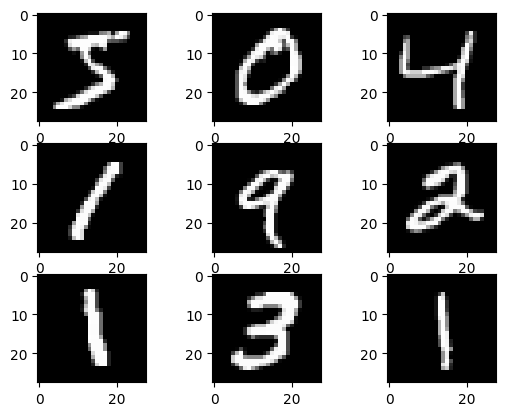

In [2]:
# plot the dataset

import matplotlib.pyplot as plt

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()


The pooling layer pads the inputs of the images, and takes the max or mean value of the pixels in the window. This is done to reduce the size of the image, and to reduce the number of parameters in the network.

In [3]:
import numpy as np
from itertools import product
# pooling the dataset
# mode = max, mean
def pooling_layer2D(X, spatial_extent=2, stride=2, mode='max'):
    X = np.asarray(X)
    h, w = X.shape
    h_out = int((h - spatial_extent) / stride) + 1
    w_out = int((w - spatial_extent) / stride) + 1
    #get the max/mean value in the spatial extent stride by stride
    Y = np.zeros((h_out, w_out))
    for i, j in product(range(h_out), range(w_out)):
        if mode == 'max':
            Y[i, j] = np.max(X[i * stride:i * stride + spatial_extent, j * stride:j * stride + spatial_extent])
        elif mode == 'mean':
            Y[i, j] = np.mean(X[i * stride:i * stride + spatial_extent, j * stride:j * stride + spatial_extent])
    return Y

Filtering is also done with a sliding window, similarly to pooling, except each output pixel is the result of a dot product between the filter and the window of pixels for each stride position in the input.

In [4]:
import numpy as np
from itertools import product
# conv the dataset
#num_filters = powers of 2
#rand = [0,1)
def filter_gen(spatial_extent, num_filters):
    return np.random.rand(num_filters, spatial_extent, spatial_extent) -0.5

def kfilter_scan(X, num_filters, spatial_extent, stride, zero_padding):
    X = np.asarray(X)
    h, w = X.shape
    #add zero padding
    if zero_padding:
        X = np.pad(X, spatial_extent // 2)
    w_out = int((w - spatial_extent + (2*zero_padding)) / stride) + 1
    h_out = int((h - spatial_extent + (2*zero_padding)) / stride) + 1

    filters = filter_gen(spatial_extent, num_filters)
    #get the max/mean value in the spatial extent stride by stride
    Y = np.zeros((h_out, w_out))
    #dot product of the filter and the image at each stride
    for i, j in product(range(h_out), range(w_out)):
        temp = X[i * stride:i * stride + spatial_extent, j * stride:j * stride + spatial_extent]
        Y[i,j] = np.dot(temp.flatten(), filters[0].flatten())      
    return Y

Add a relu activation layer, to remove any negative values from the output of the convolutional layer.

In [5]:
def relu(x):
    return np.maximum(0, x)

def relu_layer(image):
    h, w = image.shape
    new_image = np.zeros((h, w))
    for  i, j in product(range(h), range(w)):
        new_image[i,j] = relu(image[i,j])
    return new_image

Plot the data, as it stands, after running it through pooling and convolutional layers.

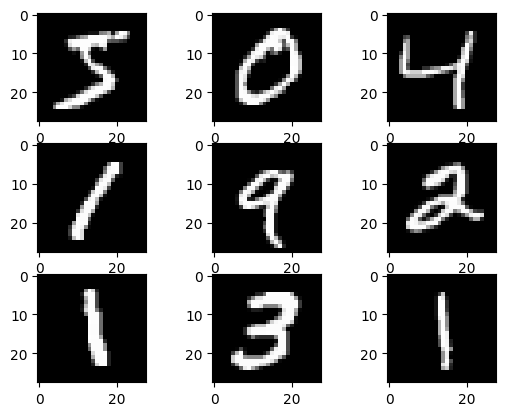

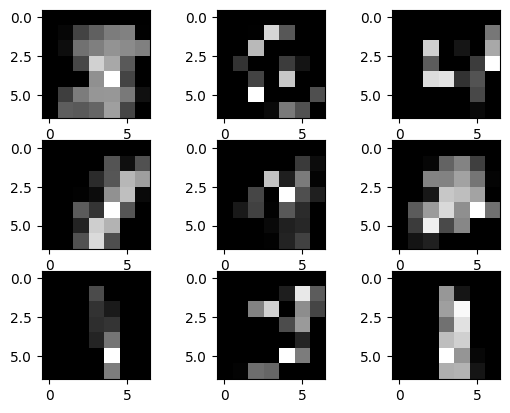

In [6]:
import matplotlib.pyplot as plt

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()

for i in range(9):
    poollayer = pooling_layer2D(train_X[i], spatial_extent=2, stride=2, mode='max')
    filtered = kfilter_scan(poollayer, num_filters=2, spatial_extent=4, stride=2, zero_padding=1)
    relued = relu_layer(filtered)
    plt.subplot(330 + 1 + i)
    plt.imshow(relued, cmap=plt.get_cmap('gray'))
plt.show()

Now, we will add a fully connected layer

In [7]:
def Dense(input, weights, bias):
    # input is a flattened image vector
    # weights is a matrix of weights
    # bias is a vector of biases
    return np.dot(input, weights) + bias

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_layer(image):
    h, w = image.shape
    new_image = np.zeros((h, w))
    for  i, j in product(range(h), range(w)):
        new_image[i,j] = softmax(image[i,j])
    return new_image



In [8]:
# define the model
def model(X):
    # conv layer
    poollayer = pooling_layer2D(X, spatial_extent=2, stride=1, mode='max')
    filtered = kfilter_scan(poollayer, num_filters=2, spatial_extent=4, stride=2, zero_padding=1)
    relued = relu_layer(filtered)
    # dense layer
    dense = Dense(relued.flatten(), weights, bias)
    # output layer
    output = softmax_layer(dense)
    return output

# call the model
weights = np.random.rand(10, 784) - 0.5
bias = np.random.rand(10, 1) - 0.5
output = model(train_X[0])
print(output)

ValueError: shapes (169,) and (10,784) not aligned: 169 (dim 0) != 10 (dim 0)